# National Health and Nutrition Examination Survey (NHANES): Confounding of Money and Education on Pregnancy

# Import libraries

In [1]:
if(!require(dplyr)){
    install.packages("dplyr", repos="https://cran.rstudio.org")
    library(dplyr)
}

if(!require(SASxport)){
    install.packages("SASxport", repos="https://cran.rstudio.org")
    library(SASxport)
}

if(!require(ggplot2)){
    install.packages("ggplot2", repos="https://cran.rstudio.org")
    library(ggplot2)
}

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: SASxport
Loading required package: ggplot2


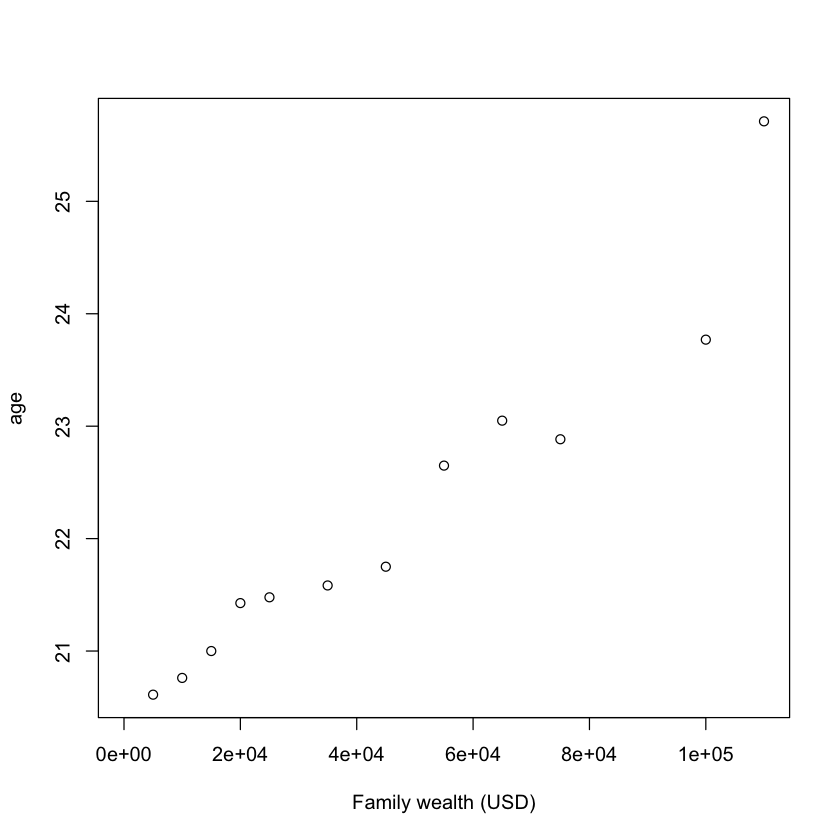

In [2]:
# Reading data
RHQ = read.xport(file="../../../data/nhanes/2015_2016/questionaires/RHQ_I.xpt")
demo = read.xport(file="../../../data/nhanes/2015_2016/demographics/DEMO_I.xpt")

# Filter pregnancy data
RHQ = RHQ %>% filter(RHQ131 < 7)
RHQ = RHQ %>% filter(RHD180 < 777)

# Filter demographic data
demo = demo %>% filter(DMDEDUC2 < 7)
demo = demo %>% filter(INDFMIN2 < 77)
demo = demo %>% filter(INDFMIN2 != 13)
demo = demo %>% filter(INDFMIN2 != 12)

# Merging both dataframs based on SEQN
ourSet = merge(demo, RHQ, type = "inner")

# Removing unused columns
set = ourSet[1]
set[2] = ourSet["RHD180"]
set[3] = ourSet["INDFMIN2"] # annual family income
set[4] = ourSet["DMDEDUC2"] # education level 20+
age = vector(mode ="numeric", length = 15)
wealth = vector(mode = "numeric", length = 15)
for(i in 1:15) {
  age[i] = colMeans(filter(set, INDFMIN2 == i))["RHD180"]
}
for(i in 1:5){
  wealth[i] = 5000*i
}
for(i in 6:10){
  wealth[i] = 25000 + 10000*(i -5)
}
wealth[14] = 100000
wealth[15] = 110000
plot(wealth, age, xlab = "Family wealth (USD)")

We see a fascinating plot of increasing age of first live birth with increasing family wealth. Note that the last data point accounts for all individuals whose family income was greater than \$100,000 USD. At this point we denote individuals with family income greater than or equal to \$45,000 as High Income Individuals.

Now we calculate the counterfactuals for the causal effect of education on giving birth while a teenager within two wealth strata.

In [3]:
LII = set %>% filter(INDFMIN2 < 8)
HII = set %>% filter(INDFMIN2 > 7)
Ltab = count(LII, RHD180)
Htab = count(HII, RHD180)

rCount = 0;
pCount = 0;
for(i in 1:5) {
  rCount = rCount + Htab[i,2]
  pCount = pCount +Ltab[i,2]
}
rCount = rCount/nrow(HII)
pCount = pCount/nrow(LII)

PD = filter(LII, DMDEDUC2 < 4)
PS = filter(LII, DMDEDUC2 > 3)
RD = filter(HII, DMDEDUC2 < 4)
RS = filter(HII,DMDEDUC2 > 3)
probs = vector(mode = "numeric", length = 4)
probs[1] = nrow(filter(PD, RHD180<20))/nrow(PD)
probs[2] = nrow(filter(PS, RHD180<20))/nrow(PD)
probs[3] = nrow(filter(RD, RHD180<20))/nrow(PD)
probs[4] = nrow(filter(RS, RHD180<20))/nrow(PD)

RichCRD = probs[4]/probs[3]
poorCRD = probs[2]/probs[1]

print(RichCRD)
print(poorCRD)

[1] 1.120879
[1] 0.3720137


For low income individuals, people with at least some college education had a teenage pregnancy rate of 18.3%, compared to 49.2% for those with less than some college education. So we can deterime the causal risk difference is -.308 within the low income strata. In a similar manner, we calculate a CRD of .0185 for the wealthy strata.